<a href="https://colab.research.google.com/github/cjmcneil/audio-restorer/blob/main/StaticGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To make 1000 gaussian white noise samples:

In [29]:
import numpy as np
n = 1000
np.random.normal(0.0, 1.0, n)

array([-7.56742140e-01, -1.53721145e-01, -7.36475975e-01,  1.01013252e+00,
       -1.30573879e+00,  4.56841981e-01,  1.03762921e+00,  4.39193884e-01,
       -1.13316609e+00, -4.66906570e-01, -1.10106501e+00, -2.09681091e+00,
        8.98187916e-01,  9.68208045e-01,  2.24876737e-01,  7.92458712e-02,
        4.50914295e-01,  1.59629891e+00, -1.16920104e-02,  8.66015208e-02,
       -1.45714289e+00,  2.42648488e+00, -1.97892691e-01, -1.62288595e+00,
        4.45925934e-01,  5.02399658e-01,  6.01461552e-01,  6.01615669e-01,
        5.30610826e-01, -6.68132815e-01, -2.40030645e-01,  7.68802685e-01,
       -3.97013365e-01,  1.71190281e-01,  7.10705371e-01, -2.21007253e-01,
        5.90319567e-01,  1.87734121e+00, -9.87102629e-01, -6.57359272e-01,
       -1.95113376e+00, -1.52855024e+00,  5.87894151e-01, -9.39104906e-01,
        9.06972843e-01,  1.12195233e+00,  9.16878664e-01,  3.33373760e-01,
        1.25003178e-01,  1.67176209e+00, -2.89868794e+00, -1.14093390e+00,
       -7.22061855e-01,  

To make pink noise:

In [30]:
def spectrum_noise(spectrum_func, samples=1024, rate=44100):
  '''
  make noise with a certain spectral density
  '''
  freqs = np.fft.rfftfreq(samples, 1.0/rate)             #real-fft frequences (not negative)
  spectrum = np.zeros_like(freqs, dtype='complex')       #make complex numbers for spectrum
  spectrum[1:] = spectrum_func(freqs[1:])                #get spectrum amplitude for all frequencies except f=0
  phases = np.random.uniform(0, 2*np.pi, len(freqs)-1)   #random phases for all frequencies except f=0
  spectrum[1:] *= np.exp(1j*phases)                      #apply random phases
  noise = np.fft.irfft(spectrum)                         #return the reverse fourier transform
  noise = np.pad(noise, (0, samples - len(noise)), 'constant')  #add zero for odd number of input samples

  return noise

def pink_spectrum(f, f_min=0, f_max=np.inf, att=np.log10(2.0)*10):
  '''
  Define a pink (1/f) spectrum
  f     = array of frequencies
  f_min = min frequency for band pass
  f_max = max frequency for band pass
  att   = attenuation per factor two in frequency in decibel
          Default is such that a factor two in frequency increase gives a factor two in power attenuation
  '''

  s = f**-(0.5 * (att/10.0)/np.log10(2.0))  #apply attenuation
  s[np.logical_or(f<f_min, f>f_max)] = 0    #apply band pass
  return s


To make a wav-file with this noise in the 5-10 kHz band scaled to the max volume, use:

In [31]:
from scipy.io import wavfile
x = spectrum_noise(lambda x:pink_spectrum(x, 5000, 10000), 4096)
x = np.int16(x/ max(abs(x)) * (2**15 - 1))
wavfile.write("static_simple.wav", 44100, x)

For 44100 samples of high pass noise above 140 Hz with 6 dB rolloff and 2 Hz modulation with random modulation phase, use:

In [32]:
from scipy.io import wavfile
samples = 44100 #number of samples
rate = 44100    #rate (Hz)
f_mod = 2       #modulation frequency (Hz)
m = 1           #modulation depth
x = spectrum_noise(lambda x: pink_spectrum(x, 140, np.inf, 6.0), samples, rate)
x *= 1.0 + m * np.sin(2*np.pi * (f_mod * (np.arange(0, samples)/rate + np.random.rand()) )) #modulation
factor = (2**13-1) / np.std(x)            #scale rms to 2^15 / 4 \approx -12 dBFS RMS
x = np.int16(x * factor)                  #scale and convert to 16-bit integer

wavfile.write("static_modulate.wav", rate, x)

Here's what ChatGPT has to say...

In [33]:
import os
import scipy
from scipy.io import wavfile
import IPython.display as ipd
import numpy as np


num_noises = 1000
noise_length = 44100
noises = np.random.normal(size=(num_noises, noise_length))
noise_list = []

for i in range(num_noises):
  scaled_noise = np.int16(noises[i] * 32767)
  noise_filename = f"noise_{i+1:03d}.wav"
  wavfile.write(noise_filename, 44100, scaled_noise)
  _, data = wavfile.read(noise_filename)
  noise_list.append(data)

# Convert the list to a numpy array
noises_array = np.array(noise_list)

# Check the shape of the array (should be (num_noises, noise_length))
print(noises_array.shape)


(1000, 44100)


In [36]:
noises_array

array([[   972,   4868, -13643, ...,  23703,   8541,  -4894],
       [-13506,  -1381,  23139, ...,  24998,   -128, -18890],
       [-24450,  11986, -14401, ...,  -9396,   5763, -11525],
       ...,
       [ 23422, -22757,   6436, ...,   8204,  29639, -25923],
       [ 18240,  23653,  -6284, ..., -11989,  24711,  12401],
       [ -2743, -28910,    290, ...,  12424,  18638, -19177]], dtype=int16)

TypeError: ignored

In [8]:
ipd.Audio("noise_997.wav")

In [9]:
ipd.Audio("noise_007.wav")

**AUDIO SOURCE SEPERATION USING NMF**

1. Load and display the audio sound signal

In [10]:
import math
#import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display 
#import IPython.display as ipd

from glob import glob

#audio_file = f"noise_070.wav"

testing_files = glob('/content/drive/MyDrive/Static_Wav_Test_Dataset/*.wav')

audio_file = testing_files[2]
sample_rate = 5512
audio_sound, sr = librosa.load(audio_file, sr = sample_rate)


In [11]:
#Display audio
ipd.Audio(audio_sound, rate = sr)

In [12]:
print(type(audio_sound))

<class 'numpy.ndarray'>


<ipython-input-13-ea0db9373607>:3: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(audio_sound, sr=sr, ax=ax, x_axis='time')


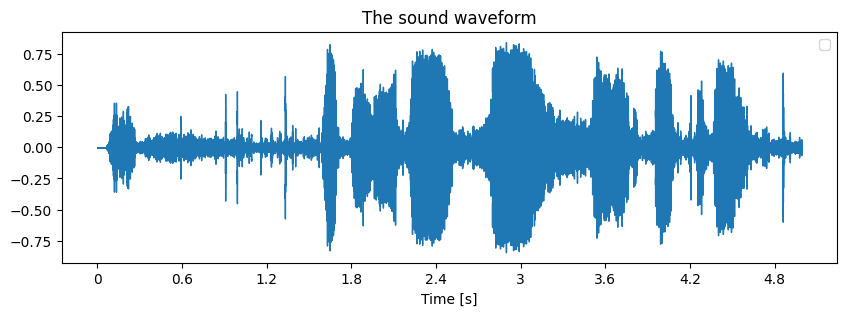

In [13]:
#Plotting the sound's signal waveform
fig, ax = plt.subplots(figsize=(10,3))
librosa.display.waveshow(audio_sound, sr=sr, ax=ax, x_axis='time')
ax.set (title='The sound waveform', xlabel='Time [s]')
ax.legend()

2. Compute STFT of the signal

Text(0.5, 1.0, 'Audio spectrogram')

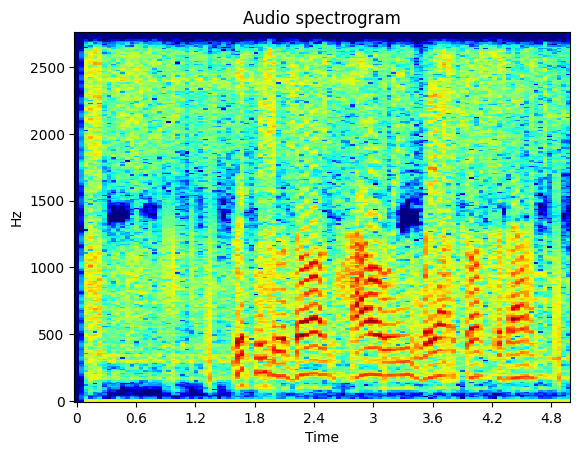

In [14]:
#Return the complex STFR
sound_stft = librosa.stft(audio_sound, n_fft = 512, hop_length=256)

#Magnitude Spectrogram
sound_stft_Magnitude = np.abs(sound_stft)

#Phase Spectrogram
sound_stft_Angle = np.angle(sound_stft)

#Plot Spectrogram
Spec = librosa.amplitude_to_db(sound_stft_Magnitude, ref=np.max)
librosa.display.specshow(Spec, y_axis = 'hz', sr=sr, hop_length = 256, x_axis='time', cmap=matplotlib.cm.jet)
plt.title('Audio spectrogram')

3. Apply the Non-Negative Matrix Factorisation:

In [15]:
# Define a function that computes the Beta Divergence

def divergence(V,W,H, beta=2):
  '''
  beta = 2 : Euclidean cost function
  beta = 1 : Kullback-Leiber cost function
  beta = 0 : Itakura-Saito cost function
  '''

  if beta == 0 : return np.sum(V/(W@H) - math.log10(V/(W@H)) - 1)

  if beta == 1 : return np.sum(V*math.log10(V/(W@H)) + (W@H - V))

  if beta == 2 : return 1/2*np.linalg.norm(W@H-V)

In [16]:
# Define the main NMF function
def NMF(V, S, beta=2, threshold=0.05, MAXITER=5000):
  '''
  inputs:
  __________
  V         : Mixture signal : |TFST|
  S         : The number of sources to extract
  beta      : Beta convergence considered, default=2 (Euclidean)
  threshold : Stop criterion
  MAXITER   : The number of maximum iterations, default=1000

  outputs:
  ___________
  W             : dictionary matrix [KxS], W>=0
  H             : activation matrix [SxN], H>=0
  cost_function : the optimized cost function over iterations

  Algorithm:
  ___________
  1) Randomly initialize W and H matrices
  2) Multiplicaitve update of W and H
  3) Repeat step 2) until convergence or after MAXITER
  '''

  counter = 0
  cost_function = []
  beta_divergence = 1

  K, N = np.shape(V)

  #Initialization of W and H matrices : The initialization is generally random
  W = np.abs(np.random.normal(loc=0, scale=2.5, size=(K,S)))
  H = np.abs(np.random.normal(loc=0, scale=2.5, size=(S,N)))

  while beta_divergence >= threshold and counter <= MAXITER:

    #Update of W and H
    H *= (W.T@(((W@H)**(beta-2))*V))/(W.T@((W@H)**(beta-1)) + 10e-10)
    W *= (((W@H)**(beta-2)*V)@H.T)/((W@H)**(beta-1)@H.T + 10e-10)

    #Compute cost function
    beta_divergence = divergence(V,W,H, beta = 2)
    cost_function.append(beta_divergence)
    counter += 1

  return W,H, cost_function

Text(0, 0.5, 'Beta Divergence for beta = 2 ')

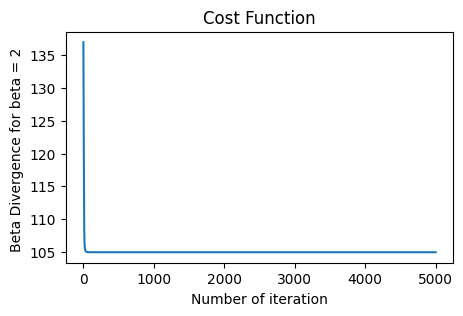

In [17]:
# Running the NMF algorithm on the data matrix
V = sound_stft_Magnitude + 1e-10
beta = 2
S = 3

# Applying the NMF function
W, H, cost_function = NMF(V,S,beta = beta, threshold = 0.05, MAXITER = 5000)

# Plotting the cost function
plt.figure(figsize=(5,3))
plt.plot(cost_function)
plt.title("Cost Function")
plt.xlabel("Number of iteration")
plt.ylabel(f"Beta Divergence for beta = {beta} ")

4. Filtering the different audio sources

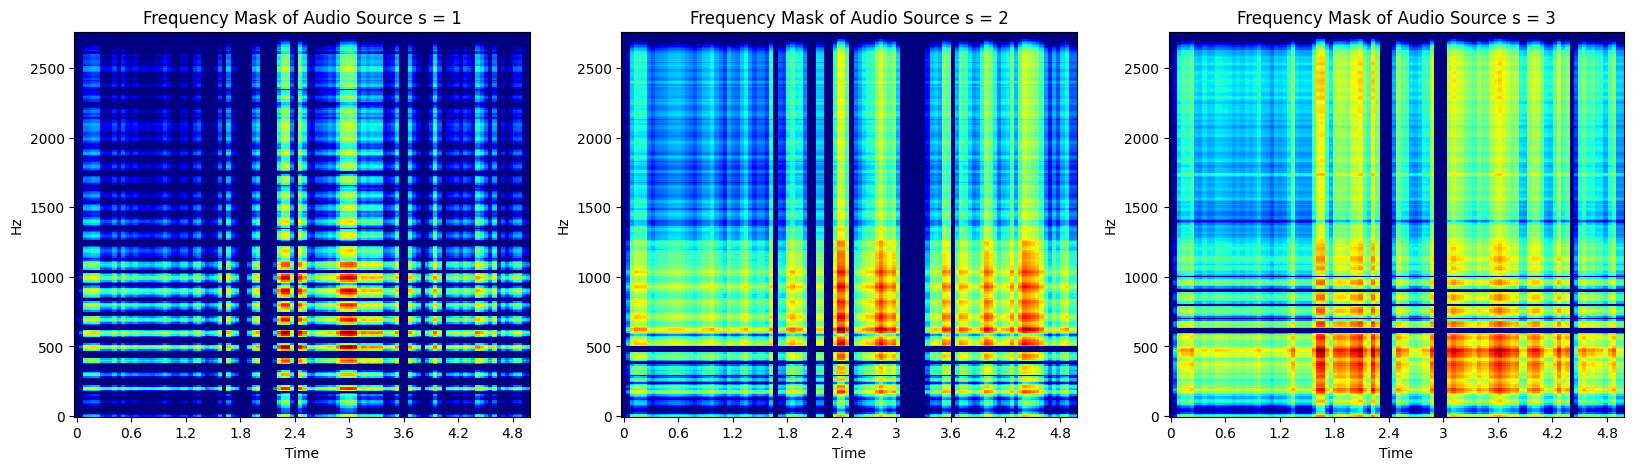

In [18]:
#After NMF, each audio source S can be expressed as frequency mask over time

f, axs = plt.subplots(nrows=1, ncols=S, figsize=(20,5))
filtered_spectrograms = []
for i in range(S):
  axs[i].set_title(f"Frequency Mask of Audio Source s = {i+1}")
  #Filter each source component
  filtered_spectrogram = W[:, [i]]@H[[i],:]
  #Compute the filtered spectrogram
  D = librosa.amplitude_to_db(filtered_spectrogram, ref = np.max)
  #Show the filtered spectrogram
  librosa.display.specshow(D,y_axis='hz', sr=sr, hop_length=256, x_axis='time', cmap=matplotlib.cm.jet, ax=axs[i])

  filtered_spectrograms.append(filtered_spectrogram)

5. Reconstructing source's audio signals

In [19]:
'''
Phase of the sources is recovered by 
simply adding the phase of the original mixture audio,
which was computed by the STFT,
to the filtered sources.

The three audio source signals are then reconstructed with the inverse STFT.
'''

reconstructed_sounds = []
for i in range(S):
  reconstruct = filtered_spectrograms[i] * np.exp(1j*sound_stft_Angle)
  new_sound   = librosa.istft(reconstruct, n_fft = 10, hop_length=256)
  reconstructed_sounds.append(new_sound)

<ipython-input-20-e669358b432c>:5: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(reconstructed_sounds[i], sr=sr,


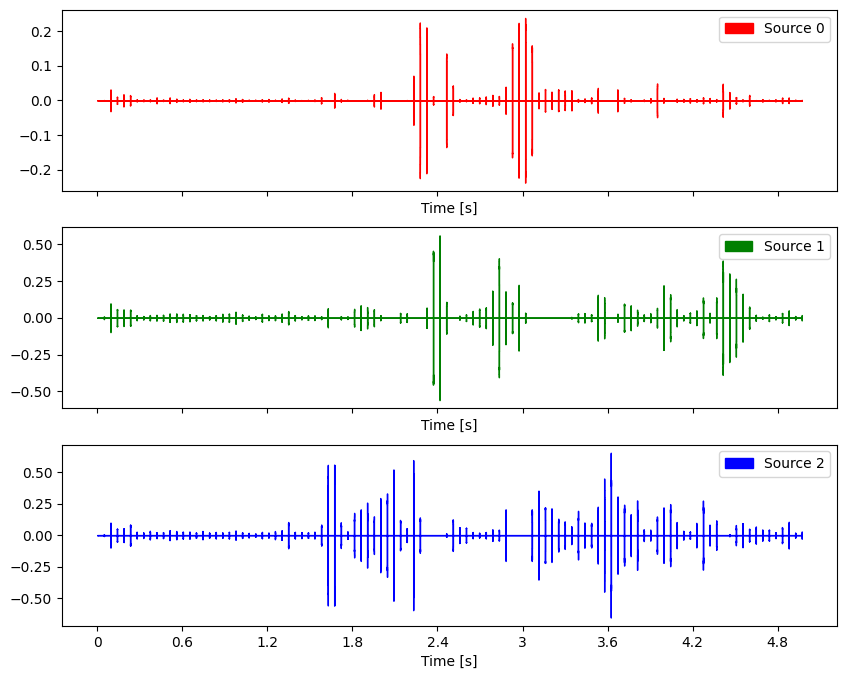

In [20]:
#Tracing the waveform
colors = ['r', 'g', 'b']
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,8))
for i in range(S):
  librosa.display.waveshow(reconstructed_sounds[i], sr=sr, 
                           color=colors[i], ax=ax[i], 
                           label=f'Source {i}', x_axis='time')
  ax[i].set(xlabel='Time [s]')
  ax[i].legend()

Playing the extracted signals

In [21]:
for i in range(S):
  ipd.display(f"Source {i}",ipd.Audio(reconstructed_sounds[i], rate=sr))

'Source 0'

'Source 1'

'Source 2'

In [22]:
ipd.Audio(reconstructed_sounds[1], rate=sr)

In [23]:
scraped_static = reconstructed_sounds[1]

In [24]:
#FORM IS SCIPY.IO.WAVFILE.WRITE(filename, rate, data)

scipy.io.wavfile.write('scraped_static.wav', sr, scraped_static)  #save signed 16-bit WAV format
print('Writing new wav', scraped_static)

Writing new wav [-2.71182107e-09 -4.16486179e-09 -6.43315443e-09 ... -1.13188279e-02
 -1.07287873e-02 -1.05104400e-02]


In [25]:
ipd.Audio('scraped_static.wav')

In [26]:
#from google.colab import files
#files.download('scraped_static.wav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>